## Wordcloud of top words from tweets

The following script finds the most frequent words in a set of tweets and creates a wordcloud of those words. The more often a term is used, the larger the word is in the wordcloud. Many times wordcloud analyses are used to see word frequencies in relation to each other, but this particular script strips out stopwords so the resulting words shed light on recurring themes.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.         

### Run CyberDH environment
The code in the cell below points to a Python environment specifically for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:   


- **nltk:** Platform for building Python programs to work with human language data.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers: dict, list, set, and tuple.

- **wordcloud:** A simple wordcloud generator in Python.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
- **zipfile:** Allows for handling of zipfiles.

Notice we import some of the packages differently. In some cases we just import the entire package when we say `import XYZ`. For some packages which are small, or, from which we are going to use a lot of the functionality it provides, this is fine. 

Sometimes when we import the package directly we say `import XYZ as X`. All this does is allow us to type `X` instead of `XYZ` when we use certain functions from the package. So we can now say `X.function()` instead of `XYZ.function()`. This saves time typing and eliminates errors from having to type out longer package names. I could just as easily type `import XYZ as potato` and whenever I use a function from the `XYZ` package I would need to type `potato.function()`. What we import the package as is up to you, but some commonly used packages have abbreviations that are standard amongst Python users such as `import pandas as pd` or `import matplotlib.pyplot as plt`. You do not need to us `pd` or `plt`, however, these are widely used and using something else could confuse other users and is generally considered bad practice. 

Other times we import only specific elements or functions from a package. This is common with packages that are very large and provide a lot of functionality, but from which we are only using a couple functions or a specific subset of the package that contains the functionality we need. This is seen when we say `from XYZ import ABC`. This is saying I only want the `ABC` function from the `XYZ` package. Sometimes we need to point to the specific location where a function is located within the package. We do this by adding periods in between the directory names, so it would look like `from XYZ.123.A1B2 import LMN`. This says we want the `LMN` function which is located in the `XYZ` package and then the `123` and `A1B2` directory in that package. 

You can also import more than one function from a package by separating the functions with commas like this `from XYZ import ABC, LMN, QRS`. This imports the `ABC`, `LMN` and `QRS` functions from the `XYZ` package.

In [2]:
from nltk.corpus import stopwords
import string
from collections import defaultdict
import wordcloud
import matplotlib.pyplot as plt
import re
import pandas as pd
import glob
import zipfile

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We are doing this so you will not need to make changes in the code further down.

First we assign the file type our data comes in to a variable. At the moment the only options are ".csv" or ".json" as these are the most popular twitter data formats. We assign the format to the `fileType` variable. It should look like this: `fileType = ".json"`.

Your data can be contained in one file or many. Therefore, you need to state if you want to read in a single document or an entire directory. If you want to read in a single document, then set `singleDoc` equal to **True**. If you want to read in an entire directory of documents then set `singleDoc` equal to **False**.

The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

The `customStop` variable is for if you have a dataset that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do **NOT** need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

The `stopLang` variable is to choose the language of the nltk stopword list you wish to use. It is currently set to `"english"`. If you need a different language, simply change `"english"` to the anglicized name of the language you wish to use (e.g. "spanish" instead of "espanol" or "german" instead of "deutsch").

The variable `encoding` is where you determine what type of encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to utf-8 at the moment as we have found it is less likely to have any problems. However, errors do occur, but the encoding errors rarely impact our results and it causes the Python code to exit. So instead of dealing with unhelpful errors we ignore the ones dealing with encoding by assigning `'ignore'` to the `errors` variable. If you want to see any encoding errors then change `'ignore'` to `None` without the quotes.

The `stopWords = []` is an empty list that will contain the final list of stop words to be removed form your dataset. What ends up in the list depends on whether you set `nltkStop` and/or `customStop` equal to **True** or **False** and if you add any additional words to the list.

In [3]:
fileType = ".json"
singleDoc = True
nltkStop = True
customStop = True
stopLang = "english"
encoding = 'utf-8'
errors = 'ignore'
stopWords = []

#### File paths
Here we are saving different file paths as variables that we need in our code. We again do this so you will not need to make as many changes to the code later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one, or we may need to access a file in this directory, but need to navigate to another folder to access other data. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names for the output in the appropriate cells down below. We save this file path as the variable `dataResults`.

Lastly, we use the file path from `dataHome` to point to the directory where our data is stored and save that as `dataRoot`. Notice though that this is dependent upon whether you chose `".json"` or `".csv"` as your `fileType` above.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
if fileType == ".csv":
    dataRoot = os.path.join(dataHome, "twitter", "CSV")
else:
    dataRoot = os.path.join(dataHome, "twitter", "JSON")

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`. You should already have chosen your language above, so there is no need to do that here.

If you wish to add additional words to the `stopWords` list, add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))
    
    stopWords.extend(['pic', 'com', 'coronavirus', 'twitter'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct path order, always putting the file name including the file extension ('.txt') last.        

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(dataHome, "twitterStopword.txt")

    with open(stopWordsFilepath, "r",encoding = encoding) as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning
The first function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Next we remove URLs by removing any text that starts with 'http' and ending with a space. Then we split the text into individual words. Next we remove any empty space, digits, stopwords, and punctuation. Finally, we return a list of cleaned words.

In [7]:
def textClean(text):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stopWords]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you don't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

You should not need to make any changes as we use the same variables containing our file paths as above, so if you need to make adjustments to the file paths, you need to make them there, specifically to the `dataRoot` variable.

In [8]:
direct = dataRoot
allZipFiles = glob.glob(os.path.join(dataRoot, "*.zip"))
for item in allZipFiles:
    fileName = os.path.splitext(direct)[0]
    zipRef = zipfile.ZipFile(item, "r")
    zipRef.extractall(fileName)
    zipRef.close()
    os.remove(item)

#### Plot wordcloud

Now we need a function that creates a wordcloud based on word frequency and plots it. To start we name the needed parameters which includes the words (`tokens`), the file path where we want to save the resulting visualization (`wcImgFilepath`), the dpi quality of the result (`dpi`), and the maximum amount of words we want the wordcloud to show (`maxWordCnt`).

The statements to execute begin by determining the word frequency. Next we need to describe the aesthetics of the wordcloud such as background color, maximum number of words, and color scheme of the wordcloud. We do this using functions and parameters from the wordcloud package and saving them as the variable `wc` for wordcloud. In this line the `colormap =` part is probably the only part you might want to change. The current color is from the RColorBrewer palette of colors. You can find other color options [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf). Just put the name of the color selection you want in quotes.

Next we need to generate the wordcloud and make sure it is generated using word frequency and displays the words, not the frequency (`wc.fit_words(freq)`). 

Then are the statements for how the wordcloud is displayed, so first we state the figures size (`plt.figure(figsize = (60,20))`). Then we want it to look like what we described in our 'wc' variable above it (`plt.imshow(wc, interpolation = 'bilinear')`), and that we are not using an x or y axis (`plt.axis("off")`). Next we want the layout to be tight instead of spread out (`plt.tight_layout()`). Then we state arguments for how we want the wordcloud saved to file (`plt.savefig(wcImgFilepath, format = 'png', dpi = dpi, bbox_inches = 'tight')`), and finally that we want to see the final result displayed in the notebook (`plt.show()`).

In [9]:
def plotWordCloud(tokens, wcImgFilepath, dpi,  maxWordCnt):

    freq = defaultdict(int)

    for t in tokens:
        freq[t] += 1

    wc = wordcloud.WordCloud(background_color = bgc, width = width, height = height, max_words = maxWordCnt, colormap = cm, min_font_size=minFont)
    

    # generate word cloud
    wc.fit_words(freq)

    # store to file
    wc.to_file(wcImgFilepath)

    # show
    plt.figure(figsize = figSz)
    plt.imshow(wc, interpolation = 'bilinear')
    
    plt.axis("off")

    plt.tight_layout()
    
    # save graph as a png image to file
    plt.savefig(wcImgFilepath, format = fmt, dpi = dpi, bbox_inches = 'tight')
    plt.show()

#### Read in a file

This function gives parameters and statements for reading in a file. First notice we have "DEclared" our "Function" using the `def` command. We have named the function `readTweets` and have given it four parameters, namely a filepath(`filepath`), what header our tweet content is found under (`textColIndex`), what encoding to use (`encoding = encoding`) and what to do with encoding errors if we get any (`errors = errors`). Notice the `encoding` and `errors` parameters are set to the variables we assigned in an earlier code cell.

Next we have an `if...else` statement. This statement says "if" we assigned `".csv"` to the `fileType` variable in an earlier code cell then run the line of code directly below this, if it is not `".csv"` (`else`) do this other line of code instead.

Then we convert the desired column to a list and assign that list to the variable `content`.

Lastly, the function returns the `content` variable when applied. 

In [10]:
def readTweets(filepath, textColIndex, encoding = encoding, errors = errors):
    if fileType == ".csv":
        tweet = pd.read_csv(filepath, encoding = encoding)
    else:
        tweet = pd.read_json(filepath, encoding = encoding)
    
    content = tweet[textColIndex].tolist()
    
    return content[1 : ]

#### Pull from a single file

This function reads a single file from which we will be counting and plotting the wordcloud. This function opens the file, reads it, adds the new line mark to the end of each row ('\n'.join(content)), so that the cleaning function we created above knows where the end of each line is. It then calls the `textClean` function to clean the text and then calls the `plotWordCloud` function we created above to plot the wordcloud.

In [11]:
def drawWordCloudFile(dataFilepath, textColIndex, encoding, errors, 
                               wcImgFilepath, dpi,  maxWordCnt):
    
    content = readTweets(dataFilepath, textColIndex, encoding, errors)
    
    text = '\n'.join(content)
    
    tokens = textClean(text)
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt)
    

#### Pull from a directory

This function reads all files in a directory from which we will be counting and plotting a wordcloud. This function 'walks' through the directory and all sub-directories, ignores hidden files which are designated by the file name beginning with a period. The function then creates a variable that says to include the entire file path for each file in the directory. Then the function opens the file, reads it, adds the new line mark to the end of each row (`text = '\n'.join(content)`), so that the cleaning function we created above knows where the end of each line is. It then calls the `textClean` function we created above. Then the function says to print the file path as soon as the file has been processed so we can see the progress and finally it calls the `plotWordCloud` plotting function we created above.

In [12]:
def drawWordCloudDirectory(dataRoot, textColIndex, encoding, errors, 
                             wcImgFilepath, dpi,  maxWordCnt):
   
    tokens = []
    
    for root, subdirs, files in os.walk(dataRoot):
        
        for filename in files:
            
            # skip hidden file
            if filename.startswith('.'):
                continue
            
            dataFilepath = os.path.join(root, filename)
            
            content = readTweets(dataFilepath, textColIndex, encoding, errors)
            text = '\n'.join(content)
            tokens.extend(textClean(text))
                
            print('Finished tokenizing text {}\n'.format(dataFilepath))
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt)

### Plot Wordcloud

Here we have an 'if else' statement that differentiates between creating a wordcloud from a single document or an entire directory, depending on if you set `singleDoc` above equal to **True** or **False**.

#### First set variables
Before we run the cell below, make sure the variables in the beginning of the notebook are set correctly. The `document` variable should contain the single file you wish to run if you are only interested in a single document. If you set `singleDoc` above to **False** then don't worry about the `document` variable. The `fileType` variable from above is automatically added to the end of the file name, so you do not need to add it. So if your file is named "myFile.csv" you only need to put "myFile" as the ".csv" is automatically added. 

Next we name the output '.png' file produced by the code below. Right now the name is a generic `"wordcloud.png"` but you may wish to change it to something that matches your data. Then we choose the output format by assigning the desired format to the `fmt` variable. It is currently set to `"png"`. Make sure the format is in quotes and matches the file format of the output file above.

Now we decide the width and height of the output image and assign those integers to the `width` and `height` variables. This mixed with the `figSz` variable (discussed below) help produce a sharper and crisper looking result, so feel free to play with these numbers.

Then we assign our `textColIndex`, `encoding`, and `errors` variables. The only one you will most likely want to change is the `textColIndex` variable. This will tell both the `drawWordCloudFile` and `drawWordCloudDirectory` functions which column in your data to process. To choose the column header put the header in quotes and assign `textColIndex` to that header. It should look like this: `textColIndex = 'text'`. When tweets are scraped/pulled directly from twitter the data comes in JSON format. The content of the tweet is 

Next we decide the color scheme. First we choose the background color and assign it to the variable `bgc`. Make sure the color you choose is in quotes. Next we choose the color scheme of the words in the wordcloud and assign it to the `cm` variable. The color scheme also needs to be in quotes. The current color scheme is `"Dark2"`. Other color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf). 

Now we set our dpi and maximum word count. The `dpi` variable gives the desired resolution of our output image and the `maxWordCnt` gives the maximum number of words we want to appear in our wordcloud.

Next we choose what the minimum font size will be for words in the wordcloud and assign the font size to the variable `minFont`.

Then we choose the size of the figure produced and assign it to the variable `figSz`. For this we need two numbers and they need to be in parentheses and separated by a comma. The first number is for the height and the second number is for the width. Feel free to adjust the numbers until you get your desired output.

#### From a single text

If you set `singleDoc` above equal to **True**, then the first part of the script in the box below uses the functions and file paths we have created to get word frequencies and plot a wordcloud from a single file. 

We start by pointing to the specific file. 

Next we save the output file based on what we set in the Variables section at the beginning of the cell. 

Then we implement the single file plotting function we created above to give us a wordcloud of most frequent thematic words in our chosen file. 

#### Wordcloud from multiple files in a directory

If you set `singleDoc` equal to **False**, then the second part of the script in the box below after `else:` now uses the functions and file paths we have created above to get word frequencies and plot a wordcloud from multiple files in a directory. 

We start by saying where we want the output file saved based on our setting in the Variables section at the beginning of the cell.  

Then we implement the directory scan plotting function we created above to give us a wordcloud of most frequent thematic words from our corpus. 

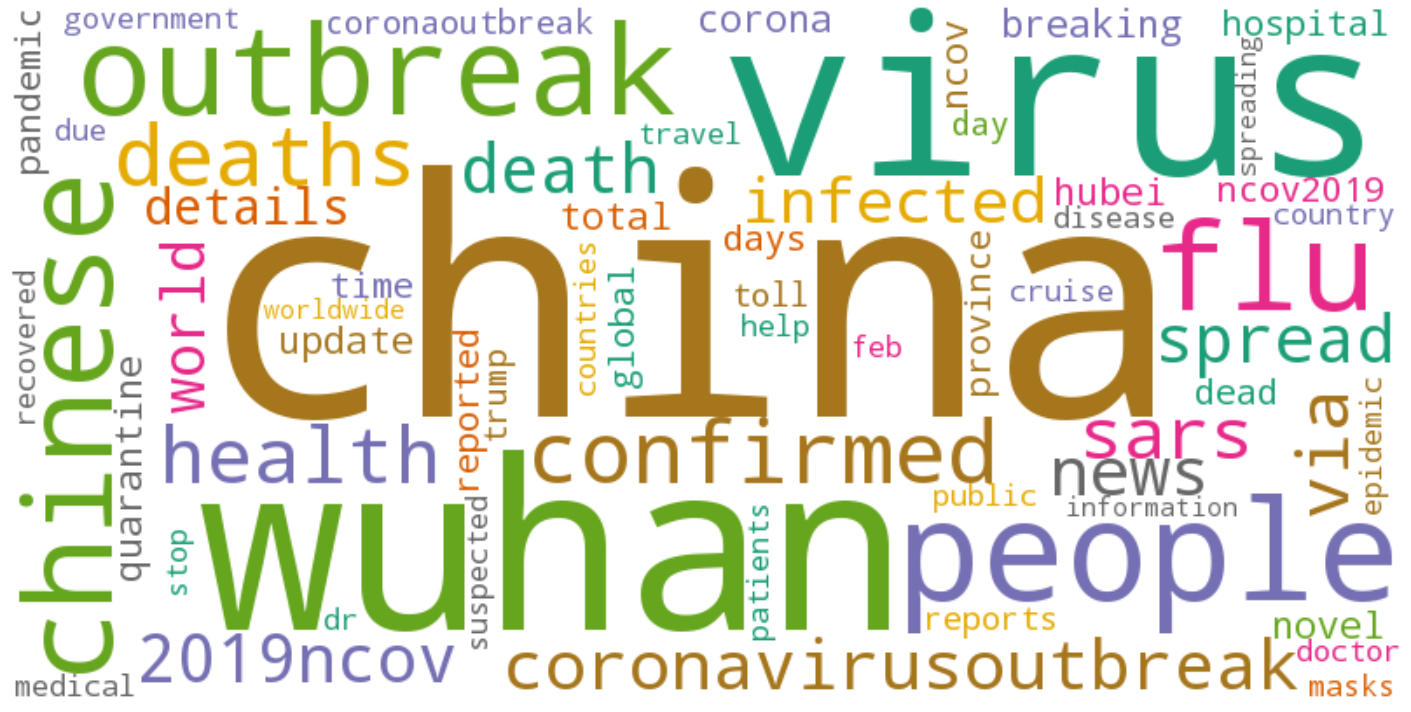

In [13]:
#Variables
document = "coronaVirusFeb01-082020" + fileType
wcOutputFile = "wordcloud.png"
fmt = "png"
width = 800
height = 400
textColIndex = "text"
bgc = "white"
cm = "Dark2"
dpi = 300
maxWordCnt = 500
minFont = 12
figSz = (20,10)

if singleDoc is True:
    # Use case one, draw word cloud from a single text

    dataFilepath = os.path.join(dataRoot, document)

    # filepath to save word cloud image
    wcImgFilepath = os.path.join(dataResults, wcOutputFile)

    # Plot wordcloud from a single file    
    drawWordCloudFile(dataFilepath, textColIndex, encoding, errors, 
                               wcImgFilepath, dpi,  maxWordCnt)
else:
    # Use case two, draw word cloud from a corpus root

    # filepath to save word cloud image
    wcImgFilepath = os.path.join(dataResults, wcOutputFile)

    # Plot wordcloud from a directory
    drawWordCloudDirectory(dataRoot, textColIndex, encoding, errors, 
                             wcImgFilepath, dpi,  maxWordCnt)

## VOILA!!